In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

'''
from google.colab import drive
drive.mount('/content/drive')
'''

# Set some parameters
BATCH_SIZE = 5 # the higher the better
IMG_WIDTH = 512 # for faster computing on kaggle
IMG_HEIGHT = 512 # for faster computing on kaggle
IMG_CHANNELS = 4

#TRAIN_PATH = '/content/drive/My Drive/UNet/Cell'
#TEST_PATH = '/content/drive/My Drive/UNet/Cell'

TRAIN_PATH = './Cell/'
TEST_PATH = './Cell/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

/home/chenzhong/miniconda3/envs/SwinT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = np.load('X.npy')
Y_train = np.load('Y.npy')

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# os.environ['WORLD_SIZE'] = '20'
# os.environ['RANK'] = '0'
# dist.init_process_group(backend='nccl')

#x, y, x_val, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)
#split dataset to 80% 10% 10%
split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0]*test_ratio)

X_test = x_val[split_test:]
#test_ids = X_test

x_val = x_val[:split_test]
y_val = y_val[:split_test]

# print(x.shape)
# print(y.shape)

########when label is matched delete this#######################
#x = x[:93]
#x_val = x_val[:93]
################################################################
x_train_tensor = torch.from_numpy(x)
y_train_tensor = torch.from_numpy(y)
# x_train_tensor = torch.tensor(x_train_tensor, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
x_train_tensor = x_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_train_tensor = y_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
#print(x_train_tensor.shape)
#print(y_train_tensor.shape)
x_val_tensor = torch.from_numpy(x_val)
y_val_tensor = torch.from_numpy(y_val)
# x_val_tensor = torch.tensor(x_val_tensor, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.float32)
x_val_tensor = x_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_val_tensor = y_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
# val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [4]:
def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


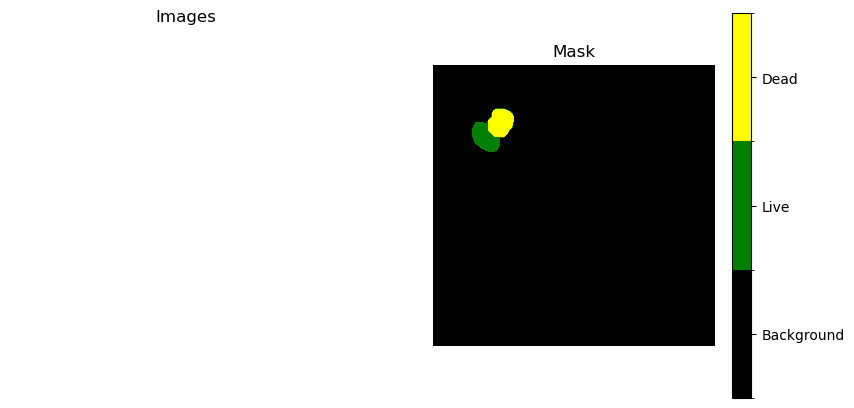

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


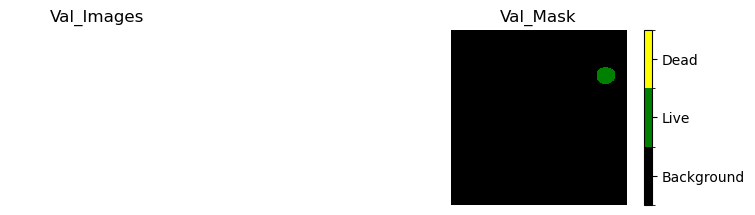

In [5]:

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[5,:,:,:], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[5],"Mask")

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_val[5,:,:,:], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[5],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [6]:
# Define IoU metric
import torch

# def mean_iou(y_pred, y_true, num_classes=3):
#     prec = []
    
#     for class_id in range(num_classes):
#         intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
#         union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
#         # Ensure union is not zero
#         union = torch.where(union == 0, torch.ones_like(union), union)
        
#         iou = intersection.float() / union.float()
#         prec.append(iou.item()) 
        
#     return torch.mean(torch.tensor(prec))

def mean_iou(y_pred, y_true, num_classes=3):
    
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    
    for class_id in range(num_classes):
       
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))




In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output

In [8]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')


In [9]:
def jaccard_loss(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    jaccard_loss = 1.0 - (intersection + 1) / (union + 1) 
    return jaccard_loss

In [10]:
import torch.backends.cudnn as cudnn

c_in = 4  # input channel 3 for RGB
c_out = 3  # output channel
if torch.cuda.device_count() > 1:
    device2 = torch.device("cuda:0")
    device1 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
#cudnn.benchmark = True
#model = torch.nn.DataParallel(model)

class ThreeChannelLogitsLoss(nn.Module):
    def __init__(self):
        super(ThreeChannelLogitsLoss, self).__init__()

    def forward(self, output, target):
        loss = 0
        for i in range(c_out):
            loss += nn.BCEWithLogitsLoss()(output[:, i, :, :], target[:, i, :, :])
        return loss / c_out

#criterion = ThreeChannelLogitsLoss()
#criterion = nn.L1Loss()    
criterion = nn.CrossEntropyLoss()
#criterion = jaccard_loss
#criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True)
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


In [11]:
# #print unet model summary

# from torchsummary import summary

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# #print(model)
# #print(f"Total Trainable Parameters: {count_parameters(model)}")
# summary(model, (3, 128, 128), device= 'cpu')


In [12]:

# Training loop
num_epochs = 100
model.to(device1)
best_loss = 1.0
best_iou = 0.0
log_file = open("training_log_new_5.txt", "w")
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        gpu = torch.cuda.get_device_properties(device1)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device1)
            
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        iou = mean_iou(outputs, labels)
        labels = labels.long()
        # # 检查标签值的最小和最大范围
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()

        if i % 50 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 100 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)

    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
    log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
    log_file.flush()

    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
        break
print(f'Best loss is {best_loss}, best iou is {best_iou}')


 28%|██▊       | 51/179 [03:43<09:30,  4.46s/it]

Epoch 1: Batch[50/179] Loss: 0.28199231028556826 IoU: 0.33638026090629863


 56%|█████▌    | 100/179 [07:22<05:51,  4.45s/it]

Epoch 1: Batch[100/179] Loss: 0.2525671970099211 IoU: 0.3366662953901687
Saving model...


 84%|████████▍ | 151/179 [11:01<01:58,  4.23s/it]

Epoch 1: Batch[150/179] Loss: 0.23601200635234515 IoU: 0.34833243817808884


100%|██████████| 179/179 [13:03<00:00,  4.37s/it]


Epoch [1/100] Loss: 0.23848409984031868 IoU: 0.3447963120111761
Saving model...


 28%|██▊       | 51/179 [03:40<09:08,  4.29s/it]

Epoch 2: Batch[50/179] Loss: 0.2171180033683777 IoU: 0.3971972799301147


 56%|█████▌    | 100/179 [07:10<05:34,  4.24s/it]

Epoch 2: Batch[100/179] Loss: 0.22109348803758622 IoU: 0.3569542717933655
Saving model...


 84%|████████▍ | 151/179 [10:47<01:59,  4.28s/it]

Epoch 2: Batch[150/179] Loss: 0.2215079798301061 IoU: 0.35695813516775765


100%|██████████| 179/179 [12:46<00:00,  4.28s/it]


Epoch [2/100] Loss: 0.21948495823577796 IoU: 0.3525280849227692
Saving model...


 28%|██▊       | 51/179 [03:41<09:32,  4.47s/it]

Epoch 3: Batch[50/179] Loss: 0.2318375812470913 IoU: 0.37626175820827484


 56%|█████▌    | 100/179 [07:16<05:45,  4.37s/it]

Epoch 3: Batch[100/179] Loss: 0.23087675504386426 IoU: 0.3662844160199165
Saving model...


 84%|████████▍ | 151/179 [11:02<02:02,  4.37s/it]

Epoch 3: Batch[150/179] Loss: 0.22203960205117862 IoU: 0.3615126858154933


100%|██████████| 179/179 [13:05<00:00,  4.39s/it]


Epoch [3/100] Loss: 0.22053817805298215 IoU: 0.358114677434527
EarlyStopping counter: 1 out of 5


 28%|██▊       | 51/179 [03:40<09:16,  4.35s/it]

Epoch 4: Batch[50/179] Loss: 0.22423551365733146 IoU: 0.3566642117500305


 56%|█████▌    | 100/179 [07:20<06:00,  4.56s/it]

Epoch 4: Batch[100/179] Loss: 0.22143236562609672 IoU: 0.3668652060627937
Saving model...


 84%|████████▍ | 151/179 [11:08<02:03,  4.42s/it]

Epoch 4: Batch[150/179] Loss: 0.22026120831569035 IoU: 0.35924907445907595


100%|██████████| 179/179 [13:14<00:00,  4.44s/it]


Epoch [4/100] Loss: 0.21888381829641385 IoU: 0.36183907199838306
Saving model...


 28%|██▊       | 51/179 [03:48<09:46,  4.58s/it]

Epoch 5: Batch[50/179] Loss: 0.21785699263215064 IoU: 0.33724223673343656


 56%|█████▌    | 100/179 [07:27<06:04,  4.62s/it]

Epoch 5: Batch[100/179] Loss: 0.21893919080495836 IoU: 0.3505740636587143
Saving model...


 84%|████████▍ | 151/179 [11:11<02:04,  4.44s/it]

Epoch 5: Batch[150/179] Loss: 0.21945169587930044 IoU: 0.3526822859048843


100%|██████████| 179/179 [13:17<00:00,  4.45s/it]


Epoch [5/100] Loss: 0.2194332932876475 IoU: 0.3506658864753872
EarlyStopping counter: 1 out of 5


 28%|██▊       | 51/179 [03:46<09:41,  4.54s/it]

Epoch 6: Batch[50/179] Loss: 0.2180252878367901 IoU: 0.3708002883195877


 56%|█████▌    | 100/179 [07:25<06:04,  4.62s/it]

Epoch 6: Batch[100/179] Loss: 0.22970007359981537 IoU: 0.37284704864025114
Saving model...


 84%|████████▍ | 151/179 [11:15<02:08,  4.60s/it]

Epoch 6: Batch[150/179] Loss: 0.22748695234457653 IoU: 0.3652870794137319


100%|██████████| 179/179 [13:21<00:00,  4.48s/it]


Epoch [6/100] Loss: 0.21907394591656476 IoU: 0.36370126944680453
EarlyStopping counter: 2 out of 5


 28%|██▊       | 51/179 [03:45<09:28,  4.44s/it]

Epoch 7: Batch[50/179] Loss: 0.2322436174750328 IoU: 0.35583804845809935


 56%|█████▌    | 100/179 [07:26<05:42,  4.34s/it]

Epoch 7: Batch[100/179] Loss: 0.22752755925059318 IoU: 0.3496235653758049
Saving model...


 84%|████████▍ | 151/179 [11:19<02:05,  4.48s/it]

Epoch 7: Batch[150/179] Loss: 0.2275989673535029 IoU: 0.34518610457579296


100%|██████████| 179/179 [13:25<00:00,  4.50s/it]


Epoch [7/100] Loss: 0.21825612956585164 IoU: 0.3432170960157277
Saving model...


 28%|██▊       | 51/179 [03:47<09:16,  4.35s/it]

Epoch 8: Batch[50/179] Loss: 0.21084830790758133 IoU: 0.384839243888855


 56%|█████▌    | 100/179 [07:27<06:04,  4.61s/it]

Epoch 8: Batch[100/179] Loss: 0.21492231845855714 IoU: 0.36430801421403886
Saving model...


 84%|████████▍ | 151/179 [11:20<02:08,  4.59s/it]

Epoch 8: Batch[150/179] Loss: 0.21828642244140306 IoU: 0.3616452944278717


100%|██████████| 179/179 [13:23<00:00,  4.49s/it]


Epoch [8/100] Loss: 0.2187627048632286 IoU: 0.3543902818717104
EarlyStopping counter: 1 out of 5


 28%|██▊       | 51/179 [03:47<09:27,  4.43s/it]

Epoch 9: Batch[50/179] Loss: 0.20440645545721053 IoU: 0.3648540818691254


 56%|█████▌    | 100/179 [07:23<05:52,  4.46s/it]

Epoch 9: Batch[100/179] Loss: 0.22275621980428695 IoU: 0.356553498506546
Saving model...


 84%|████████▍ | 151/179 [11:13<02:06,  4.51s/it]

Epoch 9: Batch[150/179] Loss: 0.21934875418742497 IoU: 0.3636325428883235


100%|██████████| 179/179 [13:19<00:00,  4.46s/it]


Epoch [9/100] Loss: 0.2181291131916659 IoU: 0.36183907166539625
Saving model...


 28%|██▊       | 51/179 [03:48<09:33,  4.48s/it]

Epoch 10: Batch[50/179] Loss: 0.22929996490478516 IoU: 0.3631166332960129


 56%|█████▌    | 100/179 [07:28<05:57,  4.52s/it]

Epoch 10: Batch[100/179] Loss: 0.22180775970220565 IoU: 0.347024005651474
Saving model...


 84%|████████▍ | 151/179 [11:19<02:06,  4.51s/it]

Epoch 10: Batch[150/179] Loss: 0.21935770670572916 IoU: 0.3549540537595749


100%|██████████| 179/179 [13:25<00:00,  4.50s/it]


Epoch [10/100] Loss: 0.2192565315928539 IoU: 0.3506658854764267
EarlyStopping counter: 1 out of 5


 28%|██▊       | 51/179 [03:49<09:41,  4.55s/it]

Epoch 11: Batch[50/179] Loss: 0.22927622109651566 IoU: 0.3562609016895294


 56%|█████▌    | 100/179 [07:28<05:52,  4.46s/it]

Epoch 11: Batch[100/179] Loss: 0.23067964635789395 IoU: 0.35952141642570495
Saving model...


 84%|████████▍ | 151/179 [11:17<02:09,  4.64s/it]

Epoch 11: Batch[150/179] Loss: 0.2222963157792886 IoU: 0.361291848619779


100%|██████████| 179/179 [13:25<00:00,  4.50s/it]


Epoch [11/100] Loss: 0.21864295584362978 IoU: 0.36183907116591596
EarlyStopping counter: 2 out of 5


 28%|██▊       | 51/179 [03:54<09:39,  4.53s/it]

Epoch 12: Batch[50/179] Loss: 0.2172327807545662 IoU: 0.37726208627223967


 56%|█████▌    | 100/179 [07:34<05:58,  4.54s/it]

Epoch 12: Batch[100/179] Loss: 0.21698830649256706 IoU: 0.3639868775010109
Saving model...


 84%|████████▍ | 151/179 [11:26<02:06,  4.51s/it]

Epoch 12: Batch[150/179] Loss: 0.21650457267959913 IoU: 0.36403300205866496


100%|██████████| 179/179 [13:35<00:00,  4.55s/it]


Epoch [12/100] Loss: 0.21864758448560812 IoU: 0.3581146787664744
EarlyStopping counter: 3 out of 5


 28%|██▊       | 51/179 [03:48<09:45,  4.58s/it]

Epoch 13: Batch[50/179] Loss: 0.21494673028588296 IoU: 0.36440945088863375


 56%|█████▌    | 100/179 [07:30<05:42,  4.34s/it]

Epoch 13: Batch[100/179] Loss: 0.21585315354168416 IoU: 0.3575513425469399
Saving model...


 84%|████████▍ | 151/179 [11:19<02:01,  4.32s/it]

Epoch 13: Batch[150/179] Loss: 0.21859453509251275 IoU: 0.3528008552392324


100%|██████████| 179/179 [13:25<00:00,  4.50s/it]


Epoch [13/100] Loss: 0.21858872032032334 IoU: 0.3506658864753872
EarlyStopping counter: 4 out of 5


 28%|██▊       | 51/179 [03:51<09:39,  4.53s/it]

Epoch 14: Batch[50/179] Loss: 0.2235802163183689 IoU: 0.3702743262052536


 56%|█████▌    | 100/179 [07:34<05:58,  4.54s/it]

Epoch 14: Batch[100/179] Loss: 0.22705313086509704 IoU: 0.3530637913942337
Saving model...


 84%|████████▍ | 151/179 [11:27<02:05,  4.49s/it]

Epoch 14: Batch[150/179] Loss: 0.22135656068722406 IoU: 0.3568687144915263


100%|██████████| 179/179 [13:32<00:00,  4.54s/it]


Epoch [14/100] Loss: 0.21808794261523465 IoU: 0.35439028137223016
Saving model...


 28%|██▊       | 51/179 [03:50<09:29,  4.45s/it]

Epoch 15: Batch[50/179] Loss: 0.20094615265727042 IoU: 0.34558083772659304


 56%|█████▌    | 100/179 [07:30<05:56,  4.51s/it]

Epoch 15: Batch[100/179] Loss: 0.21455473490059376 IoU: 0.3540982988476753
Saving model...


 84%|████████▍ | 151/179 [11:20<02:06,  4.52s/it]

Epoch 15: Batch[150/179] Loss: 0.21977113872766496 IoU: 0.35704415758450825


100%|██████████| 179/179 [13:29<00:00,  4.53s/it]


Epoch [15/100] Loss: 0.2187514193564154 IoU: 0.35066588680837407
EarlyStopping counter: 1 out of 5


 28%|██▊       | 51/179 [03:51<09:42,  4.55s/it]

Epoch 16: Batch[50/179] Loss: 0.21779938787221909 IoU: 0.3373038130998611


 56%|█████▌    | 100/179 [07:37<05:59,  4.55s/it]

Epoch 16: Batch[100/179] Loss: 0.22034494794905185 IoU: 0.33703369140625
Saving model...


 84%|████████▍ | 151/179 [11:33<02:10,  4.66s/it]

Epoch 16: Batch[150/179] Loss: 0.22002935618162156 IoU: 0.34142748177051546


100%|██████████| 179/179 [13:40<00:00,  4.58s/it]


Epoch [16/100] Loss: 0.21832174674592206 IoU: 0.35066588680837407
EarlyStopping counter: 2 out of 5


 28%|██▊       | 51/179 [03:50<09:37,  4.51s/it]

Epoch 17: Batch[50/179] Loss: 0.22659121945500374 IoU: 0.35621525704860685


 56%|█████▌    | 100/179 [07:37<06:10,  4.69s/it]

Epoch 17: Batch[100/179] Loss: 0.22966036386787891 IoU: 0.35945684254169463
Saving model...


 84%|████████▍ | 151/179 [11:29<02:08,  4.59s/it]

Epoch 17: Batch[150/179] Loss: 0.2218480424582958 IoU: 0.35688402314980827


100%|██████████| 179/179 [13:38<00:00,  4.57s/it]


Epoch [17/100] Loss: 0.21831264925402635 IoU: 0.35439028203820383
EarlyStopping counter: 3 out of 5


 28%|██▊       | 51/179 [03:55<09:52,  4.63s/it]

Epoch 18: Batch[50/179] Loss: 0.21593817472457885 IoU: 0.3642504674196243


 56%|█████▌    | 100/179 [07:39<06:00,  4.56s/it]

Epoch 18: Batch[100/179] Loss: 0.2201512321084738 IoU: 0.35374780625104907
Saving model...


 84%|████████▍ | 151/179 [11:31<02:05,  4.49s/it]

Epoch 18: Batch[150/179] Loss: 0.22299198552966118 IoU: 0.3523690277338028


100%|██████████| 179/179 [13:38<00:00,  4.57s/it]


Epoch [18/100] Loss: 0.21866917327129642 IoU: 0.3562524794866253
EarlyStopping counter: 4 out of 5


 28%|██▊       | 51/179 [03:52<09:51,  4.62s/it]

Epoch 19: Batch[50/179] Loss: 0.22359224528074265 IoU: 0.3437053632736206


 56%|█████▌    | 100/179 [07:36<06:01,  4.58s/it]

Epoch 19: Batch[100/179] Loss: 0.21877831384539603 IoU: 0.357283379137516
Saving model...


 84%|████████▍ | 151/179 [11:28<02:06,  4.51s/it]

Epoch 19: Batch[150/179] Loss: 0.2226226436595122 IoU: 0.3546083438396454


100%|██████████| 179/179 [13:36<00:00,  4.56s/it]

Epoch [19/100] Loss: 0.21880486628363252 IoU: 0.35439028203820383
EarlyStopping counter: 5 out of 5
Early stopping triggered
Best loss is 0.21808794261523465, best iou is 0.36370126944680453


Inputs shape: torch.Size([5, 4, 512, 512])
Labels shape: torch.Size([5, 512, 512, 1])
Labels unique values: [0. 1. 2.]


Model outputs before argmax: torch.Size([5, 3, 512, 512]), min: -3.687798500061035, max: 2.692775011062622
Model predicted after argmax: [0]
True labels unique values: [0. 1. 2.]


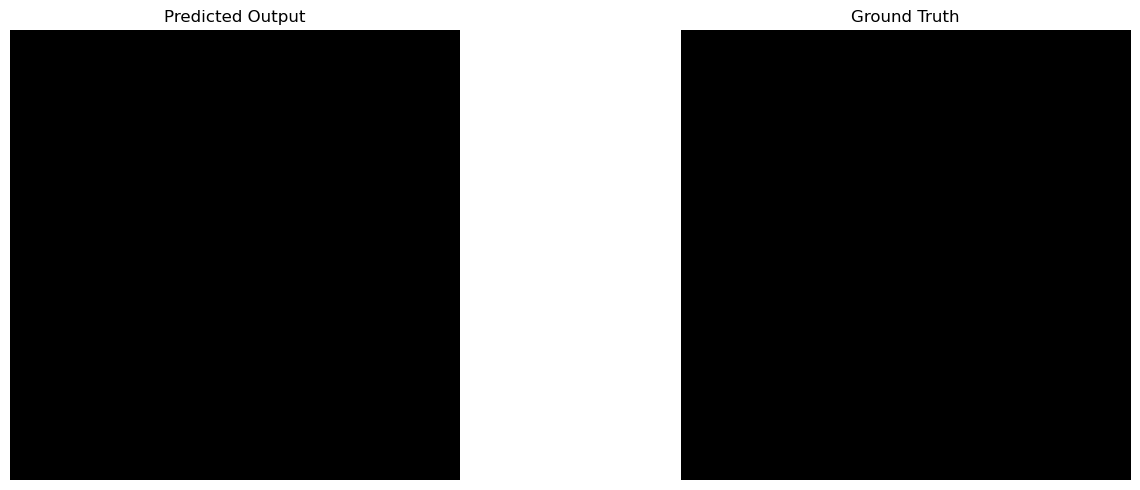

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_val_loader_predictions(model, data_loader, device, class_colors):
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            labels = labels.squeeze(1).to(device)

            print(f'Inputs shape: {inputs.shape}')
            print(f'Labels shape: {labels.shape}')
            print(f'Labels unique values: {np.unique(labels.cpu().numpy())}')

            outputs = model(inputs)
            print(f'Model outputs before argmax: {outputs.shape}, min: {outputs.min().item()}, max: {outputs.max().item()}')

            predicted = torch.argmax(outputs, dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()

            print(f'Model predicted after argmax: {np.unique(predicted)}')
            print(f'True labels unique values: {np.unique(true_labels)}')

            for i in range(len(predicted)):
                segmented_image = predicted[i]
                true_label = true_labels[i]
                height, width = segmented_image.shape

                color_image_pred = np.zeros((height, width, 3), dtype=np.uint8)
                for cls, color in class_colors.items():
                    mask = segmented_image == cls
                    color_image_pred[mask] = color

                color_image_label = np.zeros((height, width, 3), dtype=np.uint8)
                for cls, color in class_colors.items():
                    mask = true_label == cls
                    if mask.shape == (height, width):
                        color_image_label[mask] = color

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 2, 1)
                plt.imshow(color_image_pred)
                plt.title("Predicted Output")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(color_image_label)
                plt.title("Ground Truth")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                return

class_colors = {
    0: [0, 0, 0],
    1: [0, 255, 0],
    2: [255, 255, 0],
}

model.to(device2)
visualize_val_loader_predictions(model, val_loader, device2, class_colors)



In [ ]:
model = model.to(device2)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device2), labels.permute(0, 3, 1, 2).to(device2)
        outputs = model(inputs)
        labels = labels.squeeze(1)
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
preds_val = outputs

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")


100%|██████████| 23/23 [00:10<00:00,  2.26it/s]

Validation Loss: 0.23926966345828513, Validation IoU: 0.32914512831231824


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_val_predictions(inputs, predictions, labels, sample_index):
    
    input_image = inputs[sample_index, 0]  
    segmented_image = predictions[sample_index]
    true_label = labels[sample_index]

    height, width = segmented_image.shape

    class_colors = {
        0: [0, 0, 0],       
        1: [0, 255, 0],     
        2: [255, 255, 0],   
    }

    color_image_pred = np.zeros((height, width, 3), dtype=np.uint8)
    for cls, color in class_colors.items():
        mask = segmented_image == cls
        color_image_pred[mask] = color

    color_image_label = np.zeros((height, width, 3), dtype=np.uint8)
    for cls, color in class_colors.items():
        mask = true_label == cls
        color_image_label[mask] = color

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(color_image_pred)
    plt.title("Predicted Output")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(color_image_label)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

preds_val_np = preds_val.cpu().numpy()

sample_index = 0  

visualize_val_predictions(x_val_tensor.cpu().numpy(), preds_val_np, y_val_tensor.cpu().numpy(), sample_index)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def evaluate_and_save_predictions(model, X_test, batch_size, device):
    model.eval()
    all_preds = []

    X_test_tensor = torch.Tensor(X_test).to(device)
    num_samples = X_test_tensor.shape[0]

    with torch.no_grad():
        for start_idx in tqdm(range(0, num_samples, batch_size)):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_inputs = X_test_tensor[start_idx:end_idx].to(device)

            outputs = model(batch_inputs)
            batch_preds = torch.argmax(outputs, dim=1).cpu()

            all_preds.append(batch_preds)

    preds = torch.cat(all_preds, dim=0)

    return preds

batch_size = BATCH_SIZE

model.to(device2)

preds_test = evaluate_and_save_predictions(model, X_test, batch_size, device2)



100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


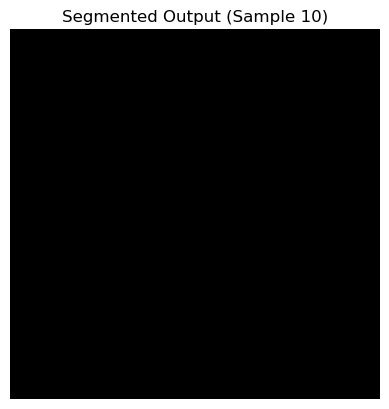

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(predictions, sample_index, class_colors):

    segmented_image = predictions[sample_index]

    height, width = segmented_image.shape

    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    for cls, color in class_colors.items():
        mask = segmented_image == cls
        color_image[mask] = color

    plt.imshow(color_image)
    plt.title(f"Segmented Output (Sample {sample_index})")
    plt.axis("off")
    plt.show()

num_samples = preds_test.size(0)

class_colors = {
    0: [0, 0, 0],        
    1: [0, 255, 0],      
    2: [255,255, 0],      
}

sample_index = 10
visualize_predictions(preds_test.numpy(), sample_index, class_colors)


In [ ]:
# model = model.to(device2)
# model.eval()


# def predict_and_threshold(model, inputs, batch_size, device):

#     model.eval()  
#     all_preds = []

#     with torch.no_grad():
#         num_samples = inputs.shape[0]

#         for start_idx in tqdm(range(0, num_samples, batch_size)):
#             end_idx = min(start_idx + batch_size, num_samples)
#             batch_inputs = inputs[start_idx:end_idx].to(device)

#             outputs = model(batch_inputs)

#             batch_preds = torch.argmax(outputs, dim=1).cpu()

#             all_preds.append(batch_preds)

#     return torch.cat(all_preds, dim=0)

# val_X = x_val_tensor.permute(0, 3, 1, 2)
# batch_size = BATCH_SIZE
# preds_val_t = predict_and_threshold(model, val_X, batch_size, device2)
# #print(preds_val_t.size())
# if preds_val_t.any() != 0:
#     print(True)
# else:
#     print(False)

# X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
# preds_test_t = predict_and_threshold(model, X_test, batch_size, device2)


# #preds_test_upsampled = [np.squeeze(pred) for pred in preds_test]


  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:10<00:00,  2.28it/s]


False


100%|██████████| 23/23 [00:10<00:00,  2.28it/s]


In [ ]:
model = model.to(device2)
model.eval()
with torch.no_grad():
    for inputs in tqdm(val_loader):
        inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
        outputs = model(inputs)
        #print(outputs.shape)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
#model=model.to(device1)
X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
val_X = x_val_tensor.permute(0,3,1,2)
with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device2))
    preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device2))


# Threshold predictions
threshold = 0.5
#preds_train_t = (preds_train > threshold).byte()
preds_val_t = (preds_val > threshold)
preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))


100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


In [ ]:
import random
import matplotlib.pyplot as plt

X_test = torch.Tensor(X_test).permute(0, 2, 3, 1)


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 3 Axes>

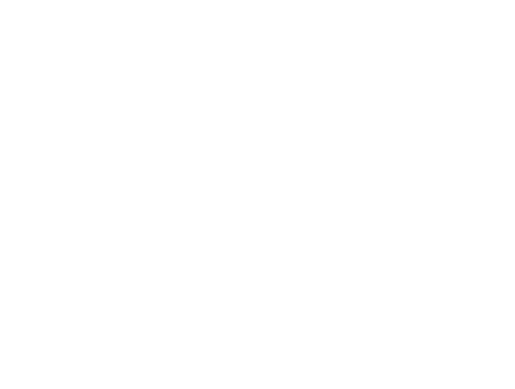

In [ ]:
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0].cpu()
predicted_mask = preds_test_t[random_index].cpu().numpy()
# predicted_mask_1 = preds_test_t[random_index][0].cpu().numpy()
# predicted_mask_2 = preds_test_t[random_index][1].cpu().numpy()

# predicted_mask = np.zeros_like(predicted_mask_1,dtype=np.uint8)
# predicted_mask[predicted_mask_1>0] = [255,255,0]
# predicted_mask[predicted_mask_2>0] = [128,0,128]

predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

# print(test_image.shape)
# print(predicted_mask.shape)
#plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(predicted_mask)
# plt.title("Predicted Mask")
show_mask(predicted_mask,"Predicted Mask")
plt.axis('off')

plt.show()


In [ ]:
for i in range(len(preds_test_t) - 1):
    predicted_mask = preds_test_t[i].cpu().numpy()
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    mask_name = os.path.join('./result/test', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./result/test', f'image_{i}.jpg')

    plt.savefig(mask_name) 
    plt.close()  

    # plt.imshow(X_test[i,:, :, 0, 0].cpu(), cmap='gray')
    # plt.axis('off')
    # plt.savefig(image_name)  
    # plt.close() 

ValueError: arrays must be of dtype byte, short, float32 or float64

Error in callback <function _draw_all_if_interactive at 0x7f25258de9d0> (for post_execute):


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 2 Axes>

In [ ]:
# for i in range(4):
#     predicted_mask = preds_test_t[i].cpu().numpy()
#     predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
#     mask1 = predicted_mask[..., 0]  # Assuming the first mask is at index 0
#     mask2 = predicted_mask[..., 1]  # Assuming the second mask is at index 1
#     if mask2.any()>0:
#         print(True)
#     # plt.subplot(i+1, 2, 1)
#     # plt.imshow(mask1,cmap='gray')
#     # plt.subplot(i+1, 2, 2)
#     # plt.imshow(mask2,cmap='gray')

In [ ]:
'''
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_train_cpu = x
Y_train_cpu = y

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow_tensor(X_train_cpu[ix])
imshow_tensor(Y_train_cpu[ix])
imshow_tensor(preds_train_t[ix].cpu())
'''


"\nimport random\nimport torch\nimport matplotlib.pyplot as plt\n\n# Define a function to display images\ndef imshow_tensor(tensor):\n    # Ensure the tensor is on the CPU and convert it to a NumPy array\n    #tensor = tensor.cpu().numpy()\n\n    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)\n    if len(tensor.shape) == 3 and tensor.shape[0] == 1:\n        tensor = tensor.squeeze(0)\n\n    # Display the image\n    plt.imshow(tensor, cmap='gray')\n    plt.show()\n\n# Move your tensors to CPU (if they are not already)\nX_train_cpu = x\nY_train_cpu = y\n\n# Perform a sanity check on some random training samples\nix = random.randint(0, len(preds_train_t))\nimshow_tensor(X_train_cpu[ix])\nimshow_tensor(Y_train_cpu[ix])\nimshow_tensor(preds_train_t[ix].cpu())\n"

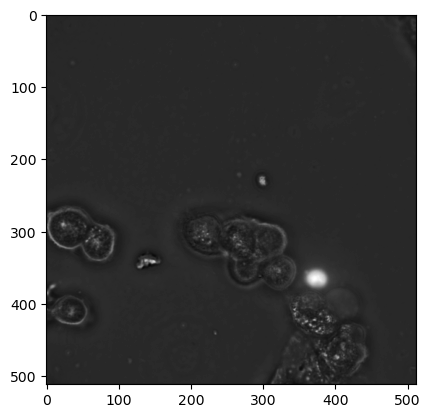

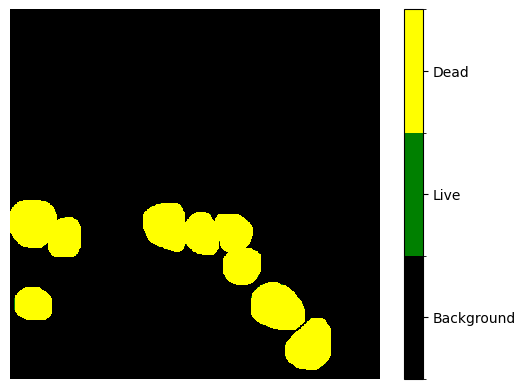

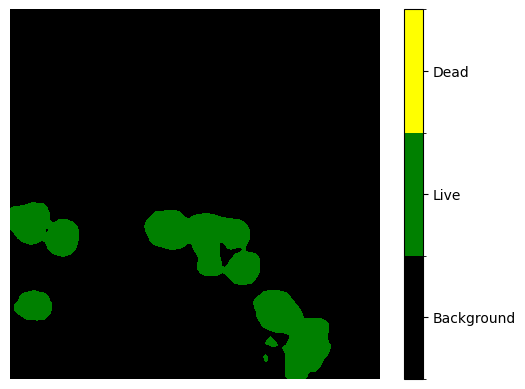

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    if tensor.shape[0] == 3:
        tensor = np.transpose(tensor, (1, 2, 0))

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t)-1)
predicted_val_mask = preds_val_t[ix].cpu().numpy()
predicted_val_mask = np.transpose(predicted_val_mask,(1,2,0))

imshow_tensor(X_val_cpu[ix,:,:,0,0])
#imshow_tensor(Y_val_cpu[ix])
show_mask(Y_val_cpu[ix])
#imshow_tensor(np.squeeze(preds_val[ix]).cpu().astype(np.float32) / 255.0)
show_mask(predicted_val_mask)

In [ ]:
import cv2

for i in range(len(preds_val_t) - 1):
    predicted_mask = preds_val_t[i].cpu().numpy()
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
    
    ground_show = Y_val_cpu[i,:,:,0]

    mask_name = os.path.join('./result/val', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./result/val', f'image_{i}.jpg')
    ground_name = os.path.join('./result/val', f'ground_truth_{i}.jpg')

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    plt.savefig(mask_name)
    plt.close()

    # plt.imshow(X_val_cpu[i, :, :, 0, 0], cmap='gray')
    # plt.axis('off')
    # plt.savefig(image_name)
    # plt.close()

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(ground_show, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    plt.savefig(ground_name)
    plt.close()


In [ ]:
# # Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# def rle_encoding(x):
#     dots = np.where(x.T.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return run_lengths

# def prob_to_rles(x, cutoff=0.5):
#     lab_img = label(x > cutoff)
#     for i in range(1, lab_img.max() + 1):
#         yield rle_encoding(lab_img == i)
# new_test_ids = []
# rles = []
# for n, id_ in enumerate(test_ids):
#     if n > len(preds_test_t) - 1:
#         n = len(preds_test_t) - 1
#     rle = list(prob_to_rles(preds_test_t[n].cpu()))
#     rles.extend(rle)
#     new_test_ids.extend([id_] * len(rle))
#print(rles)

In [ ]:
# import torch.onnx

# dummy_input = torch.randn(1, 3, 128, 128).to(device1)

# model.eval()

# onnx_file_path = "unet_model.onnx"
# torch.onnx.export(model, dummy_input, onnx_file_path, verbose=False)

# print(f"ONNX saved in: {onnx_file_path}")



In [ ]:
# image =X.to(device2)
# output = model(image)